<h2>Loading the tools</h2>
These are the imported modules and novel functions that I'll need. These are taken from the Q1 notebook.

In [1]:
# Importing the needed modules
import parselmouth
import tgt
import csv
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set() # Use seaborn's default style to make attractive graphs

# INFO HERE: https://python-graph-gallery.com/85-density-plot-with-matplotlib/
from scipy.stats import kde
from scipy.spatial import ConvexHull

from scipy.signal import savgol_filter

A function to calculate formants:

In [2]:
def get_formants(path, gender):
    """Return the cleaned formants from a sound file: smoothed, and
    voiced intervals only

    Returned as a Pandas dataframe with the following columns:
    "row", "time(s)", "nformants", "F1(Hz)", "F2(Hz)", "F3(Hz)", "F4(Hz)", "F5(Hz)"

    keyword arguments:
    path -- the path to a sound file whose formants will be found
    gender -- the gender of the (single) speaker in the sound file
              (used to tailor some formant calculation parameters)
    """        

    # CONSTANTS

    # Formant analysis parameters
    time_step = 0.005
    max_formant_num = 5
    if gender == "male":
        max_formant_freq = 5500
    elif gender == "female":
        max_formant_freq = 5000
    else:
        sys.exit("get_formants: Improper gender: {}".format(gender))
    window_length = 0.025
    preemphasis = 50

    # Pitch analysis parameters
    pitch_time_step = 0.005
    pitch_floor = 60
    max_candidates = 15
    very_accurate = False
    silence_thresh = 0.03
    voicing_thresh = 0.7
    octave_cost = 0.01
    oct_jump_cost = 0.35
    vuv_cost = 0.14
    pitch_ceiling = 600.0
    max_period = 0.02

    # Other constants
    tier = 1

    # Get raw formants
    sound = parselmouth.Sound(path)
    raw_formants = sound.to_formant_burg(time_step, max_formant_num,
                                     max_formant_freq, window_length,
                                     preemphasis)

    formant_table = parselmouth.praat.call(raw_formants, "Down to Table...",
                                           False, True, 6, False, 3, True, 3,
                                           False)

    formant_df = pd.read_csv(io.StringIO(parselmouth.praat.call(formant_table,
                                                                "List", True)),
                                         sep='\t')

    # Smooth formants: window size 5, polynomial order 3

    formant_df["F1(Hz)"] = savgol_filter(formant_df["F1(Hz)"], 5, 3)
    formant_df["F2(Hz)"] = savgol_filter(formant_df["F2(Hz)"], 5, 3)
    #formant_df["F3(Hz)"] = savgol_filter(formant_df["F3(Hz)"], 5, 3)

    # Get voiced intervals:
    pitch = sound.to_pitch_ac(pitch_time_step, pitch_floor, max_candidates,
                          very_accurate, silence_thresh, voicing_thresh,
                          octave_cost, oct_jump_cost, vuv_cost, pitch_ceiling)

    mean_period = 1/parselmouth.praat.call(pitch, "Get quantile", 0.0, 0.0, 0.5, "Hertz")
    pulses = parselmouth.praat.call([sound, pitch], "To PointProcess (cc)")
    tgrid = parselmouth.praat.call(pulses, "To TextGrid (vuv)", 0.02, mean_period)
    VUV = pd.DataFrame(pd.read_csv(io.StringIO(tgt.io.export_to_table(tgrid.to_tgt(),
                                                                      separator=','))))
    voiced_interval_array = pd.IntervalIndex.from_arrays(VUV['start_time'][VUV["text"] == "V"],
                                                     VUV['end_time'][VUV["text"] == "V"],
                                                     closed='left')
    formant_voiced = formant_df[voiced_interval_array.get_indexer(formant_df["time(s)"].values) != -1]

    # TODO: Add formant range checking here
    # For now: remove any rows where less than four formants were found
    filter = formant_voiced["nformants"] > 3
    return formant_voiced[filter]

A function to normalize the formants

In [3]:
def normalize(frame):
    """Return a dataframe of normalized formant values"""
    return (frame - frame.median()) / frame.median()

A function to make consistent plotting a little easier

In [4]:
def plot_vsd(F1n_frame, F2n_frame, plot_title,
             show_hull = True, cutoff = 0.2, iso_3d = False, save_fig = False):
    """Create a plot for a vowel space density and convex hull
    
    Note that this function assumes the F1 and F2 frames are already normalized.
    The axis limits work fine for most data encountered so far, but there is
    no guarantee that all data will fit these limits.
    
    show_hull is a logical flag to toggle whether the convex hull is plotted.
    cutoff is the value at which to draw the hull.
    iso_3d is a logical flag to toggle whether a 2d or 3d plot is made.
    save_fig is a logical flag to toggle whether the image is saved.
    """
    
    # TODO: check that incoming arguments are correct.

    fig, ax = plt.subplots()
    ax.grid()

    # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
    nbins=400
    k = kde.gaussian_kde([F2n_frame,F1n_frame])
    xi, yi = np.mgrid[F2n_frame.min():F2n_frame.max():nbins*1j,
                      F1n_frame.min():F1n_frame.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    znorm = zi / zi.max()

    # Make the basic plot    
    if iso_3d:
        ax = plt.axes(projection='3d')
        ax.plot_surface(xi, yi, znorm.reshape(xi.shape), rstride=1, cstride=1,
                        cmap=plt.cm.magma, edgecolor='none')
    else:
        plt.pcolormesh(xi, yi, znorm.reshape(xi.shape), cmap=plt.cm.magma)
        plt.colorbar()

    ax.set_ylim(2.0, -0.7)  # decreasing F1
    ax.set_xlim(0.9, -0.7)  # decreasing F2
    ax.set(xlabel='F2n', ylabel='F1n', title=plot_title)
        
    plt.rcParams['figure.figsize'] = [12, 8]

    # Calculate and plot the convex hull
    if show_hull:
        vsd = pd.DataFrame(list(zip(xi.flatten(), yi.flatten(), znorm)),
                           columns=['x', 'y', 'value'])
        vsd_filtered = vsd[vsd['value']>=cutoff]
        hull = ConvexHull(vsd_filtered[["x","y"]])
        for simplex in hull.simplices:
            plt.plot(vsd_filtered["x"].iloc[simplex], vsd_filtered["y"].iloc[simplex], 'g-')
            
    if save_fig:
        if iso_3d:
            fig.savefig("{}-iso.png".format(plot_title))
        else:
            fig.savefig("{}.png".format(plot_title))
    plt.show()

<h1>Comparing vocoid heatmaps for the same location but different speakers</h1>
I'd like to find out whether we can find similarities when different speakers from the same location tell different stories. Do speaker-specific differences overshadow the common properties of the "same" language? I'll be using two recorded stories from D02-ST01 (combined because of their shortness) and one from D02-ST03.

<h2> Getting the data</h2>
Read in the formant data from audio files into two NumPy arrays.

In [5]:
# File is the audio from a YouTube newscast of a female Arabic speaker
path1 = "D02-ST01-RTTcand Lifesaving.wav"
path2 = "D02-ST03-RTT02 Bitten by bee.wav"

file1_title = 'D02-Storyteller01'
file2_title = 'D02-Storyteller03'

file1_formants = get_formants(path1, "male")
file2_formants = get_formants(path2, "male")

file1_formants["F1n"] = normalize(file1_formants["F1(Hz)"])
file1_formants["F2n"] = normalize(file1_formants["F2(Hz)"])

file2_formants["F1n"] = normalize(file2_formants["F1(Hz)"])
file2_formants["F2n"] = normalize(file2_formants["F2(Hz)"])

It was at this point that I discovered the formant calculation function would run into a problem in the smoothing portion if F3 did not exist. This prompted me to also think that the formant calculation would probably give the best values for formants only if it was getting four formants&mdash;however, the simplest solution that would also make the current data comparable to the previous data would be to simply not smooth F3.

<h2>Displaying and comparing</h2>
Let's plot the vowel space density for both samples. Is there a difference that is visible on inspection? If inspection shows no difference, is there a better way to calculate how much difference there might be?

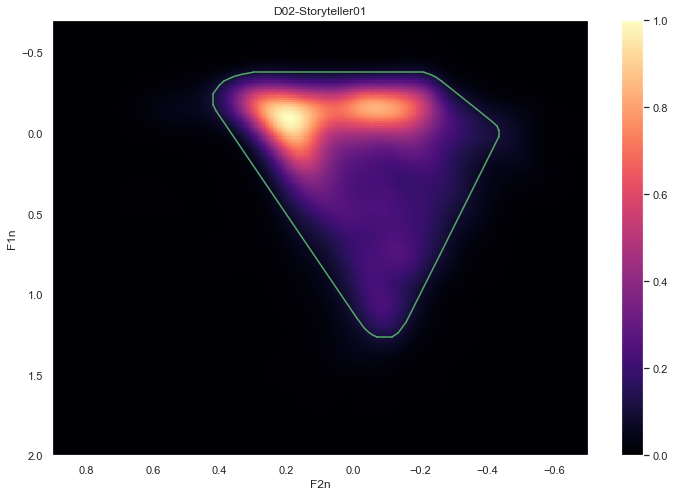

In [10]:
plot_vsd(file1_formants["F1n"], file1_formants["F2n"], file1_title, True, 0.1, False, True)

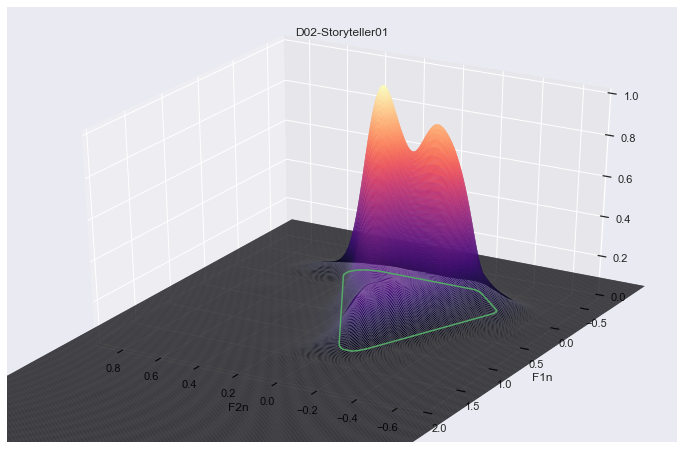

In [7]:
plot_vsd(file1_formants["F1n"], file1_formants["F2n"], file1_title, True, 0.1, True, True)

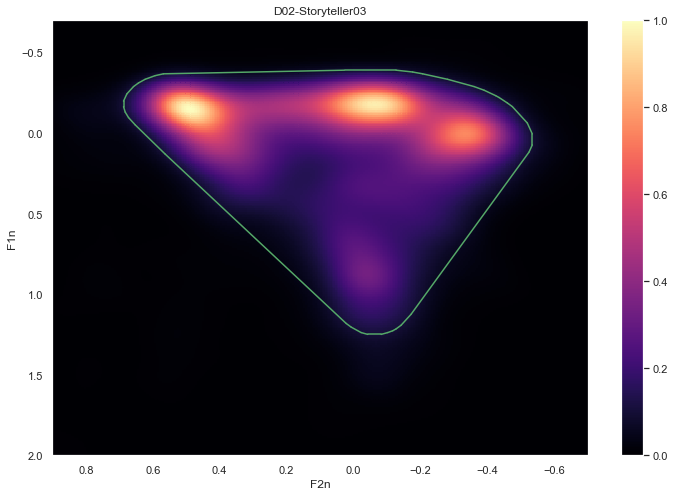

In [8]:
plot_vsd(file2_formants["F1n"], file2_formants["F2n"], file2_title, True, 0.1, False, True)

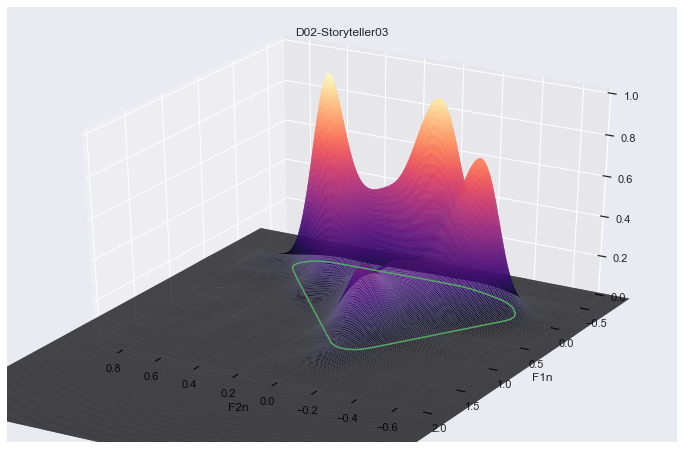

In [9]:
plot_vsd(file2_formants["F1n"], file2_formants["F2n"], file2_title, True, 0.1, True, True)